# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: 2023-04-22
* Student Name: Shawn Feng
* Student Net ID: sf8dc
* This URL: https://github.com/zeitgeistf/montecarlo/blob/main/montecarlo_demo.ipynb
* GitHub Repo URL: https://github.com/zeitgeistf/montecarlo

# The Monte Carlo Module

In [219]:
import numbers
import random

import numpy as np
import pandas as pd


DEFAULT_WEIGHT = 1.0


class Die:
    """
    A die has N sides, or "faces", and W weights, and can be rolled to select a face.

    Methods:
        - update_weight
        - roll
        - show
    """
    def __init__(self, faces: list[str | float]) -> None:
        self._die_df = pd.DataFrame({
            "faces": faces, 
            "weights": [DEFAULT_WEIGHT for _ in faces]
        })

    def update_weight(self, face: str | float, new_weight: float) -> None:
        """
        PURPOSE: This method is used to change the weight of a single side. Errors
            out if input validation fails.
        INPUT:
            1. face str | float
            2. new_weight float
        OUTPUT: None
        """
        if not face in list(self._die_df.faces):
            raise ValueError(f"Face value {face} not found in the die faces. {list(self._die_df.faces)}")

        if not isinstance(new_weight, numbers.Number):
            raise ValueError(f"New weight {new_weight} is not an instance of number.")

        index = self._die_df.faces.index[self._die_df.faces == face].to_list()[0]
        self._die_df.loc[index, 'weights'] = new_weight

    def roll(self, times=1) -> list[str | float]:
        """
        PURPOSE: this method rolss the die one or more times.
        INPUT: times int
        OUTPUT: list
        """
        return [
            random.choices(
                population=self._die_df.faces, 
                weights=self._die_df.weights, 
                k=1
            )[0]
            for i in range(times)
        ]

    def show(self) -> pd.DataFrame:
        """
        PURPOSE: This method returns the current set of faces and weights belong
            to the die.
        INPUT: None
        OUTPUT: dataframe
        """
        return self._die_df


class Game:
    """
    A game consists of rolling of one or more dice of the same kind one or more times.

    Methods:
        - _get_roll_number
        - _get_die_number
        - _roll_dice
        - play
        - show
    """
    def __init__(self, dice: list[Die]) -> None:
        self.dice = dice
        self._play_df = pd.DataFrame({})

    def _get_roll_number(self, times: int) -> list[int]:
        """
        PURPOSE: This method maps out the roll numbers base on the number of
            times user asks to roll and how many dice there are.
        INPUT: times int
        OUTPUT: list of int
        """
        return [x for _ in self.dice for x in range(1, times + 1)]

    def _get_die_number(self, times: int) -> list[int]:
        """
        PURPOSE: This method maps out the indices base on the die list index position
            from the list passed in during instantiation.
        INPUT: times int
        OUTPUT: list of int
        """
        return [index for index, _ in enumerate(self.dice) for _ in range(times)]

    def _roll_dice(self, times: int) -> list[str | float]:
        """
        PURPOSE: This method go through each die passed in the die list and roll the
            die as many times as specified until the die list is exhausted.
        INPUT: times int
        OUTPUT: list of number or string
        """
        results = []
        for die in self.dice:
            results.extend(die.roll(times=times))
        return results

    def play(self, times: int) -> None:
        """
        PURPOSE: This method will roll the dice passed in as many time as specified, and
            save the result to the instance object for future usage.
        INPUT: times int
        OUTPUT: None

        EXAMPLE: 2 dice with 6 faces roll 3 times

        roll number (index) |  die number | face rolled
                1                  0               2
                2                  0               3
                3                  0               6
                1                  1               2
                2                  1               1
                3                  1               4
        """
        roll_number = self._get_roll_number(times)
        die_number = self._get_die_number(times)
        face_rolled = self._roll_dice(times)

        self._play_df = pd.DataFrame({
            'roll_number': roll_number,
            'die_number': die_number,
            'face_rolled': face_rolled
        }).set_index('roll_number')

    def show(self, display: str = "wide") -> pd.DataFrame:
        """
        PURPOSE: This method returns to the user the results of most recent plays
            either in narrow or wide form
        INPUT: display string
        OUTPUT: Pandas dataframe

        EXAMPLE: 2 dice with 6 faces roll 3 times

        roll number (index) |  die number | face rolled
                1                  0               2
                2                  0               3
                3                  0               6
                1                  1               2
                2                  1               1
                3                  1               4
        
        NARROW: The narrow form of the dataframe will have a two-column index with the roll number
        and the die number, and a column for the face rolled.

        roll number (index) |  die number (index) | face rolled
                1                  0                      2
                2                  0                      3
                3                  0                      6
                1                  1                      2
                2                  1                      1
                3                  1                      4

        WIDE: The wide form of the dataframe will have a single column index with the roll number,
        and each die number as a column.

                die number  |        0      |      1
        roll number (index) |  face rolled  |  face rolled
                1                    2             2
                2                    3             1
                3                    6             4
        """
        if display.lower() not in ("wide", "narrow"):
            raise ValueError(
                f"Incorrect display value passed in: {display}, should be either \"wide\" or \"narrow\".")

        narrow_df = self._play_df.set_index('die_number', append=True)

        return  narrow_df \
            if display.lower() == 'narrow' else narrow_df.unstack('die_number')

class Analyzer:
    """
    An analyzer takes the results of a single game and computes various descriptive statistical properties
    about it. These properties results are available as attributes of an Analyzer object.

    Methods:
        - calculate_jackpots
        - calculate_combos
        - calculate_face_rolled_occurrences
    """
    def __init__(self, game: Game) -> None:
        self.game = game
        self.num_of_dice = len(self.game.dice)
        if self.num_of_dice < 1:
            raise ValueError("Incorrect number of dice detected, please double check and try again.")
        self.die_face_type = type(self.game.dice[0].show()['faces'][0])
        self.combos_df = None
        self.jackpots_df = None
        self.face_rolled_occurrences_df = None

    def calculate_jackpots(self) -> int:
        """
        PURPOSE: This method computes how many times the game resulted in all faces being identical.
        INPUT: None
        OUTPUT: int

        STEP 0 (original narrow dataframe generated from game class)
        roll number (index) |  die number (index) | face rolled
                1                  0                      2
                2                  0                      3
                3                  0                      6
                1                  1                      2
                2                  1                      1
                3                  1                      4

        STEP 1 (group by roll number and face rolled to get num of occurances for each combo)
        roll number (index) |  face rolled (index) |  occurrences
                1                  2                      2
                2                  1                      1
                                   3                      1
                3                  4                      1
                                   6                      1
    
        STEP 2 (only take the rows with with ocurrances equals to the number of dice)                            
        roll number (index) |  face rolled (index) |  occurrences
                1                  2                      2
        """
        occurrences_df = self.game.show(display='narrow') \
            .reset_index() \
            .groupby(by=['roll_number', 'face_rolled']) \
            .size() \
            .to_frame('occurrences')

        self.jackpots_df = occurrences_df[occurrences_df['occurrences'] == self.num_of_dice]
        return self.jackpots_df.shape[0]

    def calculate_combos(self) -> None:
        """
        PURPOSE: This method computes the distinct combinations of faces rolled, along with their counts,
            where combinations are sorted and saved as a multi-columned index
        INPUT: None
        OUTPUT: None

        STEP 0 (original narrow dataframe generated from game class)
        roll number (index) |  die number (index) | face rolled
                1                  0                      2
                2                  0                      3
                3                  0                      6
                1                  1                      2
                2                  1                      1
                3                  1                      4

        STEP 1 (group by roll number and aggregate all the face rolled within each "row" into a set 
            with only distinct values)
                    face_rolled
        roll_number
        1             (2, 2)
        2             (1, 3)
        3             (4, 6)
    
        STEP 2 (conduct another group by on the indexed face rolled set and count their occurrences)
                     ocurrances
        face_rolled
        (1, 3)            1
        (2, 2)            1
        (4, 6)            1
        """
        df = self.game.show(display='narrow') \
            .groupby('roll_number') \
            .agg({'face_rolled': tuple})
        
        df['face_rolled'] = [tuple(sorted(x)) for x in df['face_rolled']]

        self.combos_df = df \
            .astype({'face_rolled': 'str'}) \
            .groupby('face_rolled') \
            .size() \
            .to_frame('occurrences') \
            .sort_values('occurrences', ascending=False)

    def calculate_face_rolled_occurrences(self) -> None:
        """
        PURPOSE: This method computes how many times a given face is rolled in each event.
        INPUT: None
        OUTPUT: None

        SAVED DF STRUCTURE:
               face rolled  |   1   |   2   |   3   |   4   |   5   |   6   |
        roll number (index) |  
                1               0       2       0       0       0       0
                2               1       0       1       0       0       0
                3               0       0       0       1       0       1
        """
        self.face_rolled_occurrences_df = self.game.show(display='narrow') \
            .reset_index() \
            .groupby(by=['roll_number', 'face_rolled']).size() \
            .unstack('face_rolled') \
            .fillna(0)


# Test Module

In [237]:
import unittest

import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

from montecarlo import Analyzer, Die, Game


class DieTestSuite(unittest.TestCase):

    def test_die_initialization_1(self):
        """
        PURPOSE: A dataframe with numeric faces and weights gets
            created upon initialization
        """
        faces = [1, 2, 3, 4, 5, 6]
        die = Die(faces)

        self.assertTrue(
            isinstance(die._die_df, pd.DataFrame), "Die DF should be an instance of Pandas dataframe")

        self.assertEqual(
            list(die._die_df.faces), faces, "Dataframe faces column value should match with input")

        self.assertEqual(
            len(die._die_df.faces), len(die._die_df.weights), "Length of faces and weights should match")

        expected_default_weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
        self.assertEqual(
            list(die._die_df.weights), expected_default_weights, "Default weights should all equal to 1.0")

    def test_die_initialization_3(self):
        """
        PURPOSE: A dataframe with string faces and weights gets
            created upon initialization
        """
        faces = ["H", "T"]
        die = Die(faces)

        self.assertTrue(
            isinstance(die._die_df, pd.DataFrame), "Die DF should be an instance of Pandas dataframe")

        self.assertEqual(
            list(die._die_df.faces), faces, "Dataframe faces column value should match with input")

        self.assertEqual(
            len(die._die_df.faces), len(die._die_df.weights), "Length of faces and weights should match")

        expected_default_weights = [1.0, 1.0]
        self.assertEqual(
            list(die._die_df.weights), expected_default_weights, "Default weights should all equal to 1.0")


    def test_die_update_weight(self):
        """
        PURPOSE: Weight should be updated upon calling update_weight method
        """
        faces = [1, 2, 3, 4, 5, 6]
        die = Die(faces)

        expected_new_weight = 2.0
        die.update_weight(face=faces[0], new_weight=expected_new_weight)

        self.assertEqual(die._die_df.weights[0], expected_new_weight, "Updated weight should get reflected")

    def test_die_update_weight_with_incorrect_face(self):
        """
        PURPOSE: Test if this method errors out when passing in a face value that doesn't exists
            in the dataframe.
        """
        faces = [1, 2, 3, 4, 5, 6]
        die = Die(faces)

        incorrect_face = 7
        correct_new_weight = 2.0
        self.assertRaises(ValueError, die.update_weight, incorrect_face, correct_new_weight)

    def test_die_update_weight_with_incorrect_weight(self):
        """
        PURPOSE: Test if this method errors out when passing in a weight that is not numeric
        """
        faces = [1, 2, 3, 4, 5, 6]
        die = Die(faces)

        correct_face = 1
        incorrect_new_weight = "2.0"
        self.assertRaises(ValueError, die.update_weight, correct_face, incorrect_new_weight)

    def test_die_roll(self):
        """
        PURPOSE: Test if roll method returns correct output when triggered
        """
        faces = [1, 2, 3, 4, 5, 6]
        die = Die(faces)

        res1 = die.roll(times=0)
        self.assertEqual(res1, [], "Empty list should be returned when there's no face input.")

        res2 = die.roll(times=1)
        self.assertTrue(isinstance(res2, list), "Roll method return should be a list.")
        self.assertTrue(res2[0] in faces, "Roll result should come from one of the faces.")

        res3 = die.roll(times=3)
        self.assertEqual(len(res3), 3, "Number of output should match with number of rolls.")
        for i in range(3):
            self.assertTrue(res3[i] in faces, "Roll result should come from one of the faces.")

    def test_die_show(self):
        """
        PURPOSE: Test if the show method can display the result dataframe correctly
        """
        faces = [1, 2, 3, 4, 5, 6]
        expected_weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
        die = Die(faces)

        actual_df = die.show()
        self.assertTrue(isinstance(actual_df, pd.DataFrame))

        expected_df = pd.DataFrame({
            'faces': faces,
            'weights': expected_weights
        })
        assert_frame_equal(actual_df, expected_df)


class GameTestSuite(unittest.TestCase):

    def test_game_initialization(self):
        """
        PURPOSE: Test to make sure game object can be successfully created.
        """
        faces = [1, 2, 3, 4, 5, 6]
        die = Die(faces)

        game = Game(dice=[die])
        assert_frame_equal(
            game.dice[0].show(), die.show(), "Class object contained Die object should match with the input Die.")

    def test_get_roll_number(self):
        """
        PURPOSE: Ensure correct roll number mapped list can be returned.
        """
        faces = [1, 2, 3, 4, 5, 6]
        die1 = Die(faces)
        die2 = Die(faces)
        one_time = 1
        three_times = 3

        # With only 1 die
        game = Game(dice=[die1])
        # 1 time
        actual_roll_number = game._get_roll_number(times=one_time)
        expected_roll_number = [1]
        self.assertEqual(actual_roll_number, expected_roll_number)
        # 3 times
        actual_roll_number = game._get_roll_number(times=three_times)
        expected_roll_number = [1, 2, 3]
        self.assertEqual(actual_roll_number, expected_roll_number)

        # With multiple dice 
        game = Game(dice=[die1, die2])
        # 1 time
        actual_roll_number = game._get_roll_number(times=one_time)
        expected_roll_number = [1, 1]
        self.assertEqual(actual_roll_number, expected_roll_number)
        # 3 times
        actual_roll_number = game._get_roll_number(times=three_times)
        expected_roll_number = [1, 2, 3, 1, 2, 3]
        self.assertEqual(actual_roll_number, expected_roll_number)

    def test_get_die_number(self):
        """
        PURPOSE: Ensure correct die number mapped list can be returned.
        """
        faces = [1, 2, 3, 4, 5, 6]
        die1 = Die(faces)
        die2 = Die(faces)
        one_time = 1
        three_times = 3

        # With only 1 die
        game = Game(dice=[die1])
        # 1 time
        actual_die_number = game._get_die_number(times=one_time)
        expected_die_number = [0]
        self.assertEqual(actual_die_number, expected_die_number)
        # 3 times
        actual_die_number = game._get_die_number(times=three_times)
        expected_die_number = [0, 0, 0]
        self.assertEqual(actual_die_number, expected_die_number)

        # With multiple dice 
        game = Game(dice=[die1, die2])
        # 1 time
        actual_die_number = game._get_die_number(times=one_time)
        expected_die_number = [0, 1]
        self.assertEqual(actual_die_number, expected_die_number)
        # 3 times
        actual_die_number = game._get_die_number(times=three_times)
        expected_die_number = [0, 0, 0, 1, 1, 1]
        self.assertEqual(actual_die_number, expected_die_number)

    def test_roll_dice(self):
        """
        PURPOSE: Ensure correct dice rolling results can be returned.
        """
        faces = [1, 2, 3, 4, 5, 6]
        die1 = Die(faces)
        die2 = Die(faces)
        one_time = 1
        three_times = 3

        # With only 1 die
        game = Game(dice=[die1])
        # 1 time
        actual_face_rolled = game._roll_dice(times=one_time)
        self.assertTrue(actual_face_rolled[0] in faces)
        # 3 times
        actual_face_rolled = game._roll_dice(times=three_times)
        for i in range(three_times * 1):
            self.assertTrue(actual_face_rolled[i] in faces)

        # With multiple dice 
        game = Game(dice=[die1, die2])
        # 1 time
        actual_face_rolled = game._roll_dice(times=one_time)
        for i in range(one_time * 2):
            self.assertTrue(actual_face_rolled[i] in faces)
        # 3 times
        actual_face_rolled = game._roll_dice(times=three_times)
        for i in range(three_times * 2):
            self.assertTrue(actual_face_rolled[i] in faces)

    def test_play(self):
        """
        PURPOSE: Ensure play method returns correct dataframe.
        """
        faces = [1, 2, 3, 4, 5, 6]
        die1 = Die(faces)
        die2 = Die(faces)
        one_time = 1
        three_times = 3

        # With only 1 die
        game = Game(dice=[die1])
        # 1 time
        game.play(times=one_time)
        actual = game._play_df.drop(['face_rolled'], axis=1)
        expected = pd.DataFrame({
            'roll_number': [1],
            'die_number': [0]
        }).set_index('roll_number')
        assert_frame_equal(actual, expected)

        # 3 times
        game.play(times=three_times)
        actual = game._play_df.drop(['face_rolled'], axis=1)
        expected = pd.DataFrame({
            'roll_number': [1, 2, 3],
            'die_number': [0, 0, 0]
        }).set_index('roll_number')
        assert_frame_equal(actual, expected)

        # With multiple die
        game = Game(dice=[die1, die2])
        # 1 time
        game.play(times=one_time)
        actual = game._play_df.drop(['face_rolled'], axis=1)
        expected = pd.DataFrame({
            'roll_number': [1, 1],
            'die_number': [0, 1]
        }).set_index('roll_number')
        assert_frame_equal(actual, expected)

        # 3 times
        game.play(times=three_times)
        actual = game._play_df.drop(['face_rolled'], axis=1)
        expected = pd.DataFrame({
            'roll_number': [1, 2, 3, 1, 2, 3],
            'die_number': [0, 0, 0, 1, 1, 1]
        }).set_index('roll_number')
        assert_frame_equal(actual, expected)

    def test_show_wide(self):
        """
        PURPOSE: Ensure show method returns the dataframe in the correct
            format when display mode is set to wide.
        """
        faces = [1, 2, 3, 4, 5, 6]
        die1 = Die(faces)
        die2 = Die(faces)
        one_time = 1
        three_times = 3

        # With only 1 die
        game = Game(dice=[die1])
        # 1 time
        game.play(times=one_time)
        actual = game.show(display="wide").drop(['face_rolled'], axis=1)
        expected = pd.DataFrame({
            'roll_number': [1],
            'die_number': [0]
        }).set_index(keys=['roll_number', 'die_number']).unstack('die_number')
        self.assertTrue(actual.equals(expected))

        # 3 times
        game.play(times=three_times)
        actual = game.show(display="wide").drop(['face_rolled'], axis=1)
        expected = pd.DataFrame({
            'roll_number': [1, 2, 3],
            'die_number': [0, 0, 0]
        }).set_index(keys=['roll_number', 'die_number']).unstack('die_number')
        self.assertTrue(actual.equals(expected))

        # With multiple dice
        game = Game(dice=[die1, die2])
        # 1 time
        game.play(times=one_time)
        actual = game.show(display="wide").drop(['face_rolled'], axis=1)
        expected = pd.DataFrame({
            'roll_number': [1, 1],
            'die_number': [0, 1]
        }).set_index(keys=['roll_number', 'die_number']).unstack('die_number')
        self.assertTrue(actual.equals(expected))

        # 3 times
        game.play(times=three_times)
        actual = game.show(display="wide").drop(['face_rolled'], axis=1)
        expected = pd.DataFrame({
            'roll_number': [1, 2, 3, 1, 2, 3],
            'die_number': [0, 0, 0, 1, 1, 1]
        }).set_index(keys=['roll_number', 'die_number']).unstack('die_number')
        self.assertTrue(actual.equals(expected))

    def test_show_narrow(self):
        """
        PURPOSE: Ensure show method returns the dataframe in the correct
            format when display mode is set to narrow.
        """
        faces = [1, 2, 3, 4, 5, 6]
        die1 = Die(faces)
        die2 = Die(faces)
        one_time = 1
        three_times = 3

        # With only 1 die
        game = Game(dice=[die1])
        # 1 time
        game.play(times=one_time)
        actual = game.show(display="narrow").replace([1, 2, 3, 4, 5, 6], 0)
        expected = pd.DataFrame({
            'roll_number': [1],
            'die_number': [0],
            'face_rolled': [0]
        }).set_index(keys=['roll_number', 'die_number'])
        self.assertTrue(actual.equals(expected))

        # 3 times
        game.play(times=three_times)
        actual = game.show(display="narrow").replace([1, 2, 3, 4, 5, 6], 0)
        expected = pd.DataFrame({
            'roll_number': [1, 2, 3],
            'die_number': [0, 0, 0],
            'face_rolled': [0, 0, 0]
        }).set_index(keys=['roll_number', 'die_number'])
        self.assertTrue(actual.equals(expected))

        # With multiple dice
        game = Game(dice=[die1, die2])
        # 1 time
        game.play(times=one_time)
        actual = game.show(display="narrow").replace([1, 2, 3, 4, 5, 6], 0)
        expected = pd.DataFrame({
            'roll_number': [1, 1],
            'die_number': [0, 1],
            'face_rolled': [0, 0]
        }).set_index(keys=['roll_number', 'die_number'])
        self.assertTrue(actual.equals(expected))

        # 3 times
        game.play(times=three_times)
        actual = game.show(display="narrow").replace([1, 2, 3, 4, 5, 6], 0)
        expected = pd.DataFrame({
            'roll_number': [1, 2, 3, 1, 2, 3],
            'die_number': [0, 0, 0, 1, 1, 1],
            'face_rolled': [0, 0, 0, 0, 0, 0]
        }).set_index(keys=['roll_number', 'die_number'])
        self.assertTrue(actual.equals(expected))


class AnalyzerTestSuite(unittest.TestCase):
    def test_analyzer_initialization(self):
        """
        PURPOSE: Ensure analyzer object is instantiated correctly.
        """
        faces = [1, 2, 3, 4, 5, 6]
        die1 = Die(faces)
        die2 = Die(faces)
        game = Game(dice=[die1, die2])
        analyzer = Analyzer(game=game)
        self.assertEqual(analyzer.game, game)
        self.assertEqual(analyzer.die_face_type, np.int64)

        faces = ['H', 'T']
        die = Die(faces)
        game = Game(dice=[die])
        analyzer = Analyzer(game=game)
        self.assertEqual(analyzer.game, game)
        self.assertEqual(analyzer.die_face_type, str)

        self.assertEqual(analyzer.combos_df, None)
        self.assertEqual(analyzer.jackpots_df, None)
        self.assertEqual(analyzer.face_rolled_occurrences_df, None)

    def test_analyzer_initialization_falsy(self):
        """
        PURPOSE: Instantiation should fail if no dice is detected from the input.
        """
        game = Game(dice=[])
        self.assertRaises(ValueError, Analyzer, game)

    def test_calculate_jackpots(self):
        """
        PURPOSE: Ensure correct number of identical face rolled is returned.
        """
        faces = [1, 2, 3, 4, 5, 6]
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)
        dice = [die1, die2, die3]
        game = Game(dice=dice)
        game.play(times=3)
        analyzer = Analyzer(game=game)
        num_of_jackpots = analyzer.calculate_jackpots()

        self.assertTrue(isinstance(num_of_jackpots, int))
        self.assertLessEqual(num_of_jackpots, len(dice))

    def test_calculate_combos(self):
        """
        PURPOSE: Ensure correct combos are returned from the method.
        """
        faces = [1, 2, 3, 4, 5, 6]
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)
        dice = [die1, die2, die3]
        game = Game(dice=dice)
        game.play(times=3)
        analyzer = Analyzer(game=game)
        analyzer.calculate_combos()

        self.assertEqual(analyzer.combos_df.shape, (len(dice), 1))
        self.assertEqual(analyzer.combos_df.ndim, 2)

    def test_ccalculate_face_rolled_occurrences(self):
        """
        PURPOSE: Ensure the transformation happens correctly when unstack face rolled.
        """
        faces = [1, 2, 3, 4, 5, 6]
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)
        game = Game(dice=[die1, die2, die3])
        game.play(times=3)
        analyzer = Analyzer(game=game)
        analyzer.calculate_face_rolled_occurrences()

        actual_df = analyzer.face_rolled_occurrences_df
        self.assertEqual(list(actual_df.index), [1, 2, 3])


# if __name__ == "__main__":
#     unittest.main(verbosity=3)


# Test Results

In [245]:
print(open('test_output.txt', 'r').read())

(project) ➜ montecarlo main ✗ (?) python tests/montecarlo_tests.py
test_analyzer_initialization (__main__.AnalyzerTestSuite.test_analyzer_initialization)
PURPOSE: Ensure analyzer object is instantiated correctly. ... ok
test_analyzer_initialization_falsy (__main__.AnalyzerTestSuite.test_analyzer_initialization_falsy)
PURPOSE: Instantiation should fail if no dice is detected from the input. ... ok
test_calculate_combos (__main__.AnalyzerTestSuite.test_calculate_combos)
PURPOSE: Ensure correct combos are returned from the method. ... ok
test_calculate_jackpots (__main__.AnalyzerTestSuite.test_calculate_jackpots)
PURPOSE: Ensure correct number of identical face rolled is returned. ... ok
test_ccalculate_face_rolled_occurrences (__main__.AnalyzerTestSuite.test_ccalculate_face_rolled_occurrences)
PURPOSE: Ensure the transformation happens correctly when unstack face rolled. ... ok
test_die_initialization_1 (__main__.DieTestSuite.test_die_initialization_1)
PURPOSE: A dataframe with numeric f

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

In [1]:
# Install dependencies
%pip install matplotlib
%pip install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 3.8 MB/s eta 0:00:00m eta 0:00:01m0:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 1.0 MB/s eta 0:00:00 MB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.39.3-py3-none-any.whl (1.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 60.4 kB/s eta 0:00:001m291.9 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 1.7 MB/s eta 0:00:000m eta 0:00:010:01
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/sf/Desktop/me/msds/s1/montecarlo
  Preparing metadata (setup.py) ... done
  Attempting uninstall: montecarlo
    Found existing installation: montecarlo 0.1.0
    Uninstalling montecarlo-0.1.0:
      Successfully uninstalled monte

In [2]:
# Import dependencies
import matplotlib.pyplot as plt
from montecarlo import Analyzer, Die, Game

In [3]:
# Set up common constants and variables
DEBUG = True

## Scenario 1

### A 2-headed coin
1. Create a fair coin (with faces H and T) and one unfair coin, in which one of the faces has a weight of 5 and the others 1.
2. Play a game of 1000 flips with all fair dice.
3. Play a game of 1000 flips with two unfair dice and one fair die.
4. For each game, use an Analyzer object to determine the
relative frequency of jackpots – getting either all Hs or all Ts.
5. Compute relative frequency as the number of jackpots over the
total number of rolls.
6. Show your results, comparing the two relative frequencies, in a
simple bar chart.

In [4]:
# STEP 1
# Set up constants
s1_rounds_of_play = 1000

# Set coin faces
s1_faces = ['H', 'T']

# Create and configure coins
s1_fair_coin = Die(faces=s1_faces)
s1_unfair_coin = Die(faces=s1_faces)
s1_unfair_coin.update_weight(face='H', new_weight=5.0)

# Debug logging
if DEBUG:
    print(f'Scenario 1 fair coin: \n{s1_fair_coin.show()}\n')
    print(f'Scenario 2 unfair coin: \n{s1_unfair_coin.show()}\n')

Scenario 1 fair coin: 
  faces  weights
0     H      1.0
1     T      1.0

Scenario 2 unfair coin: 
  faces  weights
0     H      5.0
1     T      1.0



In [5]:
# STEP 2
s1_game_1 = Game(dice=[
    s1_fair_coin,
    s1_fair_coin,
    s1_fair_coin
])
s1_game_1.play(times=s1_rounds_of_play)

In [6]:
# STEP 3
s1_game_2 = Game(dice=[
    s1_unfair_coin,
    s1_unfair_coin,
    s1_fair_coin
])
s1_game_2.play(times=s1_rounds_of_play)

In [7]:
# STEP 4
s1_analyzer_1 = Analyzer(game=s1_game_1)
s1_num_of_jackpots_1 = s1_analyzer_1.calculate_jackpots()

s1_analyzer_2 = Analyzer(game=s1_game_2)
s1_num_of_jackpots_2 = s1_analyzer_2.calculate_jackpots()

In [8]:
# STEP 5
s1_jackpot_freq_1 = s1_num_of_jackpots_1 / s1_rounds_of_play
s1_jackpot_freq_2 = s1_num_of_jackpots_2 / s1_rounds_of_play

# Debug logging
if DEBUG:
    print(f'Scenario 1 jackpot frequency 1: {s1_jackpot_freq_1}\n')
    print(f'Scenario 1 jackpot frequency 2: {s1_jackpot_freq_2}\n')

Scenario 1 jackpot frequency 1: 0.233

Scenario 1 jackpot frequency 2: 0.373



Text(0.5, 1.0, 'Relative frequency of Jackpots for each game')

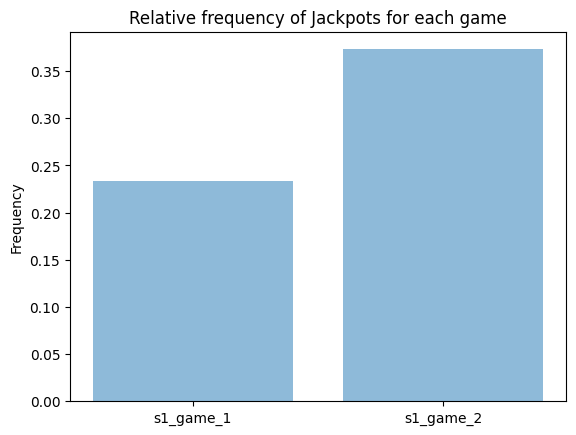

In [9]:
# STEP 6
plt.bar(['s1_game_1', 's1_game_2'], [s1_jackpot_freq_1, s1_jackpot_freq_2], align='center', alpha=0.5)
plt.ylabel('Frequency')
plt.title('Relative frequency of Jackpots for each game')

## Scenario 2

### A 6-sided die

1. Create a fair die and two unfair dice, all of six sides with the faces 1 through 6. One unfair die (Type 1) will weight 6 five times more than the others (i.e. it has weight of 5 and the others a weight of 1 each). The other unfair die (Type 2) will weight 1 five times more than the others.
2. Play a game of 10000 rolls with 5 fair dice.
3. Play a game of 10000 rolls with 2 unfair dice of type 1, 1 unfair
die of type 2, and the rest fair dice.
4. For each game, use an Analyzer object to determine the
relative frequency of jackpots and show your results,
comparing the two relative frequencies, in a simple bar chart.
5. Also compute 10 most frequent combinations of faces for each
game. Plot each of these as bar charts.

In [21]:
# STEP 1
# Set up constants
s2_rounds_of_play = 10000

# Set coin faces
s2_faces = [1, 2, 3, 4, 5, 6]

# Create and configure dice
s2_fair_die = Die(faces=s2_faces)

s2_unfair_die_type_1 = Die(faces=s2_faces)
s2_unfair_die_type_1.update_weight(face=6, new_weight=5.0)

s2_unfair_die_type_2 = Die(faces=s2_faces)
s2_unfair_die_type_2.update_weight(face=1, new_weight=5.0)


# Debug logging
if DEBUG:
    print(f'Scenario 2 fair die: \n{s2_fair_die.show()}\n')
    print(f'Scenario 2 unfair die type 1: \n{s2_unfair_die_type_1.show()}\n')
    print(f'Scenario 2 unfair die type 2: \n{s2_unfair_die_type_2.show()}\n')

Scenario 2 fair die: 
   faces  weights
0      1      1.0
1      2      1.0
2      3      1.0
3      4      1.0
4      5      1.0
5      6      1.0

Scenario 2 unfair die type 1: 
   faces  weights
0      1      1.0
1      2      1.0
2      3      1.0
3      4      1.0
4      5      1.0
5      6      5.0

Scenario 2 unfair die type 2: 
   faces  weights
0      1      5.0
1      2      1.0
2      3      1.0
3      4      1.0
4      5      1.0
5      6      1.0



In [22]:
# STEP 2
s2_game_1 = Game(dice=[
    s2_fair_die,
    s2_fair_die,
    s2_fair_die,
    s2_fair_die,
    s2_fair_die
])
s2_game_1.play(times=s2_rounds_of_play)

In [23]:
# STEP 3
s2_game_2 = Game(dice=[
    s2_unfair_die_type_1,
    s2_unfair_die_type_1,
    s2_unfair_die_type_2,
    s2_fair_die,
    s2_fair_die
])
s2_game_2.play(times=s2_rounds_of_play)

Scenario 2 jackpot frequency 1: 0.0006

Scenario 2 jackpot frequency 2: 0.0007



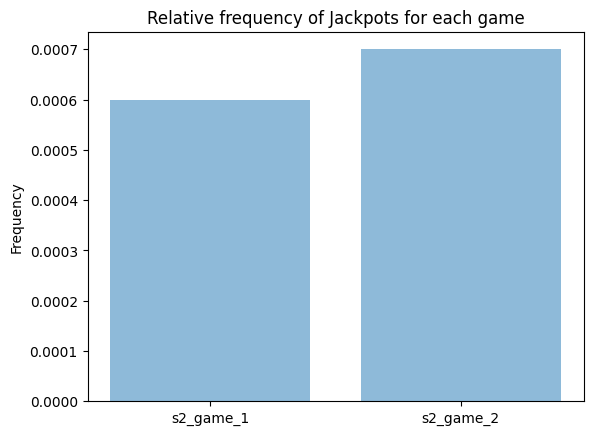

In [24]:
# STEP 4
s2_analyzer_1 = Analyzer(game=s2_game_1)
s2_num_of_jackpots_1 = s2_analyzer_1.calculate_jackpots()
s2_jackpot_freq_1 = s2_num_of_jackpots_1 / s2_rounds_of_play

s2_analyzer_2 = Analyzer(game=s2_game_2)
s2_num_of_jackpots_2 = s2_analyzer_2.calculate_jackpots()
s2_jackpot_freq_2 = s2_num_of_jackpots_2 / s2_rounds_of_play

# Debug logging
if DEBUG:
    print(f'Scenario 2 jackpot frequency 1: {s2_jackpot_freq_1}\n')
    print(f'Scenario 2 jackpot frequency 2: {s2_jackpot_freq_2}\n')

# Plot
plt.bar(['s2_game_1', 's2_game_2'], [s2_jackpot_freq_1, s2_jackpot_freq_2], align='center', alpha=0.5)
plt.ylabel('Frequency')
plt.title('Relative frequency of Jackpots for each game')

plt.show()

In [25]:
# STEP 5
s2_analyzer_1.calculate_combos()
s2_analyzer_2.calculate_combos()

top_10_combo_1 = s2_analyzer_1.combos_df.iloc[:10]
top_10_combo_2 = s2_analyzer_2.combos_df.iloc[:10]
if DEBUG:
    print(f'Scenario 2 game 1 top 10 highest occurred combos: \n{top_10_combo_1}\n')
    print(f'Scenario 2 game 2 top 10 highest occurred combos: \n{top_10_combo_2}\n')

Scenario 2 game 1 top 10 highest occurred combos: 
                 occurrences
face_rolled                 
(1, 2, 3, 5, 6)          161
(2, 3, 4, 5, 6)          161
(1, 2, 3, 4, 5)          154
(1, 2, 4, 5, 6)          151
(1, 2, 3, 4, 6)          140
(1, 3, 4, 5, 6)          125
(1, 4, 5, 6, 6)           99
(1, 1, 2, 4, 6)           97
(1, 2, 2, 4, 6)           95
(1, 1, 2, 4, 5)           95

Scenario 2 game 2 top 10 highest occurred combos: 
                 occurrences
face_rolled                 
(1, 2, 3, 6, 6)          211
(1, 4, 5, 6, 6)          200
(1, 2, 4, 6, 6)          199
(1, 2, 5, 6, 6)          197
(1, 3, 4, 6, 6)          187
(1, 3, 5, 6, 6)          180
(1, 3, 4, 5, 6)          176
(1, 1, 2, 6, 6)          171
(1, 1, 5, 6, 6)          169
(1, 2, 3, 5, 6)          165



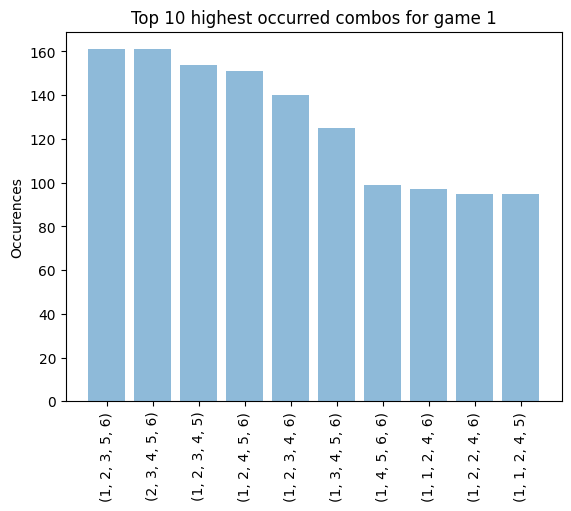

In [26]:
# Plot 1
plt.bar(top_10_combo_1.index, top_10_combo_1.occurrences, align='center', alpha=0.5)

plt.ylabel('Occurences')
plt.xticks(rotation='vertical')
plt.title('Top 10 highest occurred combos for game 1')

plt.show()

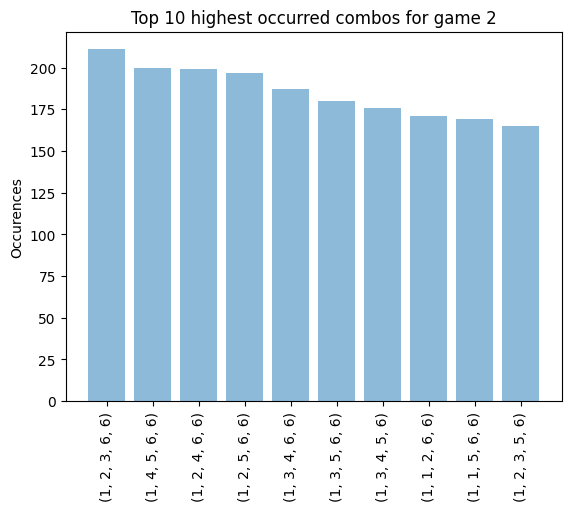

In [27]:
# Plot 2
plt.bar(top_10_combo_2.index, top_10_combo_2.occurrences, align='center', alpha=0.5)

plt.ylabel('Occurences')
plt.xticks(rotation='vertical')
plt.title('Top 10 highest occurred combos for game 2')

plt.show()

## Scenario 3

### Letters of the Roman Alpha

1. Create a "die" of letters from a to z with weights based on their frequency of usage.
2. Play a game involving 5 of these dice with 1000 rolls.
3. How many combos can you that look like actual English
words? NOTE: "combo" here just means resulting sequence,
not literally combination as opposed to permutation.
4. Based on your eye count, what is the relative frequency of
these words versus the rest?
5. Note: the Notebook will supply the weights for the letters.

Note: The method to compute faces per roll may be useful in computing jackpots.

In [28]:
# STEP 1
# Set up constants
s3_rounds_of_play = 1000
frequency_of_letters = {
    'A': 8.4966,
    'B': 2.0720,
    'C': 4.5388,
    'D': 3.3844,
    'E': 11.1607,
    'F': 1.8121,
    'G': 2.4705,
    'H': 3.0034,
    'I': 7.5448,
    'J': 0.1965,
    'K': 1.1016,
    'L': 5.4893,
    'M': 3.0129,
    'N': 6.6544,
    'O': 7.1635,
    'P': 3.1671,
    'Q': 0.1962,
    'R': 7.5809,
    'S': 5.7351,
    'T': 6.9509,
    'U': 3.6308,
    'V': 1.0074,
    'W': 1.2899,
    'X': 0.2902,
    'Y': 1.7779,
    'Z': 0.2722
}

# Set coin faces
s3_faces = frequency_of_letters.keys()

# Create and configure dice
s3_die = Die(faces=s3_faces)
[s3_die.update_weight(face=k, new_weight=v) for k, v in frequency_of_letters.items()]


# Debug logging
if DEBUG:
    print(f'Scenario 3 die: \n{s3_die.show()}\n')

Scenario 3 die: 
   faces  weights
0      A   8.4966
1      B   2.0720
2      C   4.5388
3      D   3.3844
4      E  11.1607
5      F   1.8121
6      G   2.4705
7      H   3.0034
8      I   7.5448
9      J   0.1965
10     K   1.1016
11     L   5.4893
12     M   3.0129
13     N   6.6544
14     O   7.1635
15     P   3.1671
16     Q   0.1962
17     R   7.5809
18     S   5.7351
19     T   6.9509
20     U   3.6308
21     V   1.0074
22     W   1.2899
23     X   0.2902
24     Y   1.7779
25     Z   0.2722



In [29]:
# STEP 2
s3_game = Game(dice=[
    s3_die,
    s3_die,
    s3_die,
    s3_die,
    s3_die
])
s3_game.play(times=s3_rounds_of_play)

In [40]:
# STEP 3
s3_analyzer = Analyzer(game=s3_game)
s3_analyzer.calculate_combos()

if DEBUG:
    display(s3_analyzer.combos_df)  # Uncomment follow code to view complete output
    # import pandas as pd
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3):
    #     display(s3_analyzer.combos_df)

,occurrences
face_rolled,
"('A', 'E', 'M', 'S', 'T')",3
"('A', 'L', 'N', 'N', 'R')",2
"('A', 'D', 'E', 'I', 'N')",2
"('A', 'R', 'S', 'S', 'T')",2
"('A', 'E', 'P', 'T', 'U')",2
...,...
"('A', 'O', 'R', 'S', 'T')",1
"('A', 'R', 'R', 'U', 'W')",1
"('A', 'R', 'S', 'T', 'U')",1


In [39]:
# STEP 4
observation = "Base on eyeballing the result from previous step, it is very difficult to find English word"
print(observation)

print(f'Scenario 3 English word relative frequency is very close to 0')

Base on eyeballing the result from previous step, it is very difficult to find English word
Scenario 3 English word relative frequency is very close to 0


# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [37]:
!ls -lRF -o

total 784
-rw-r--r--  1 shawnfeng    1059 Apr 22 11:59 LICENSE
-rw-r--r--  1 shawnfeng     155 May  1 22:41 Pipfile
-rw-r--r--  1 shawnfeng   20820 May  1 22:42 Pipfile.lock
-rw-r--r--  1 shawnfeng    3933 May  1 21:23 README.md
drwxr-xr-x  6 shawnfeng     192 Apr 22 21:59 assets/
drwxr-xr-x  5 shawnfeng     160 Apr 22 12:29 montecarlo/
drwxr-xr-x  7 shawnfeng     224 May  1 22:42 montecarlo.egg-info/
-rw-r--r--  1 shawnfeng  354505 May  1 22:59 montecarlo_demo.ipynb
-rw-r--r--  1 shawnfeng     400 Apr 22 12:11 setup.py
-rw-r--r--  1 shawnfeng    3002 Apr 22 20:57 test_output.txt
drwxr-xr-x  4 shawnfeng     128 Apr 22 12:07 tests/

./assets:
total 7176
-rw-r--r--@ 1 shawnfeng    22368 Apr 22 12:01 FinalProjectInstructions.pdf
-rw-r--r--  1 shawnfeng     4597 Apr 22 12:01 FinalProjectSubmissionTemplate.ipynb
-rw-------@ 1 shawnfeng   870368 Apr 22 21:58 montecarlo_demo.html
-rw-r--r--@ 1 shawnfeng  2767326 Apr 22 21:59 montecarlo_demo.pdf

./montecarlo:
total 32
-rw-r--r--  1 shawnfeng 

# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [38]:
# Installation commands
%pip install -e .

Obtaining file:///Users/sf/Desktop/me/msds/s1/montecarlo
  Preparing metadata (setup.py) ... done
  Attempting uninstall: montecarlo
    Found existing installation: montecarlo 0.1.0
    Uninstalling montecarlo-0.1.0:
      Successfully uninstalled montecarlo-0.1.0
  Running setup.py develop for montecarlo

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
